In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
new_df = pd.read_csv('new_df.csv', index_col=0, decimal='.')

In [3]:
new_df.head()

,I,Iu,Imax,Entropy,BasketNum,SumExp,AvgExp
CustomerID,,,,,,,
12347.0,182,103,47,4.943568,7,4310.00,615.714286
12348.0,31,22,17,3.163994,4,1797.24,449.310000
12349.0,73,73,73,3.897416,1,1757.55,1757.550000
12350.0,17,17,17,2.772224,1,334.40,334.400000
12352.0,85,59,18,3.850853,8,2506.04,313.255000


In [4]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df_transformed = scaler.fit_transform(new_df.values)

In [5]:
df_transformed

array([[0.2397351 , 0.32484076, 0.37096774, ..., 0.23076923, 0.14978073,
        0.1242248 ],
       [0.0397351 , 0.06687898, 0.12903226, ..., 0.11538462, 0.06238148,
        0.09046236],
       [0.09536424, 0.22929936, 0.58064516, ..., 0.        , 0.06100098,
        0.35589651],
       ...,
       [0.01456954, 0.03503185, 0.0483871 , ..., 0.03846154, 0.00606253,
        0.01736266],
       [1.        , 0.8343949 , 0.85483871, ..., 0.57692308, 0.07273405,
        0.02586494],
       [0.09139073, 0.18471338, 0.2983871 , ..., 0.07692308, 0.06377416,
        0.12355776]])

## K-Means
Parameters:

K: the number of clusters.
We exploited the Elbow method to find the best value for K, calculating the mean of SSE for each value from 1 to 20 clusters.

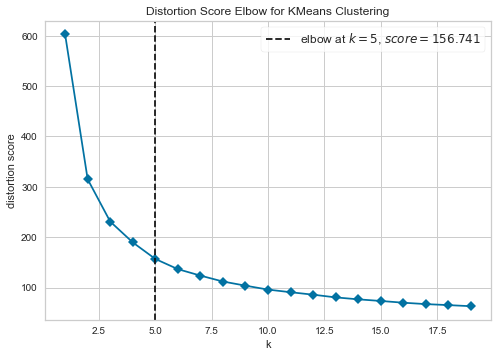

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [6]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
km=KMeans()
visualizer= KElbowVisualizer(km, k=(1,20), metric='distortion', timings=False)
visualizer.fit(df_transformed)
visualizer.show()

In [7]:
n_clusters=visualizer.elbow_value_
kmeans=KMeans(n_clusters=n_clusters,n_init=20,max_iter=100)
kmeans.fit(df_transformed)
hist,bins=np.histogram(kmeans.labels_,bins=range(0,len(set(kmeans.labels_))+1))

In [8]:
dict(zip(bins, hist))

{0: 1687, 1: 454, 2: 1192, 3: 214, 4: 624}

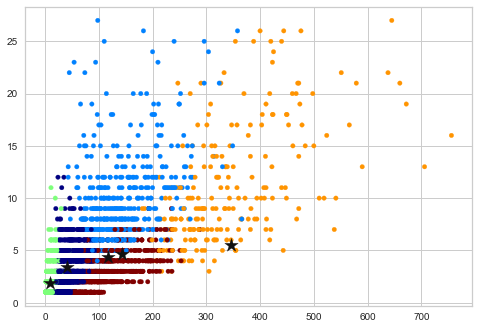

In [15]:
centers=scaler.inverse_transform(kmeans.cluster_centers_)
plt.scatter(new_df['I'],new_df["BasketNum"],c=kmeans.labels_,s=20,cmap=plt.cm.get_cmap("jet"))
plt.scatter(centers[:, 0], centers[:, 3], s=200, marker='*', c='k')
plt.tick_params(axis='both', which='major', labelsize=10)
plt.show()

C:\Users\PREHA MADAAN\AppData\Local\Temp\ipykernel_280\4256609972.py:2: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax2=fig.gca(projection='3d')


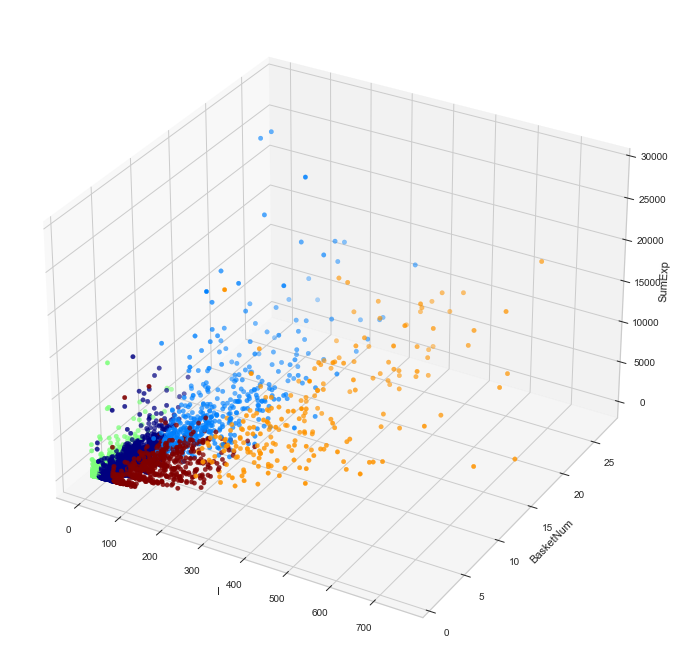

In [17]:
fig=plt.figure(figsize=(16,12))
ax2=fig.gca(projection='3d')
ax2.scatter(new_df['I'],new_df['BasketNum'],new_df['SumExp'],c=kmeans.labels_, marker='o', cmap=plt.cm.get_cmap('jet'))
ax2.set_xlabel('I')
ax2.set_ylabel('BasketNum')
ax2.set_zlabel('SumExp')
plt.show()


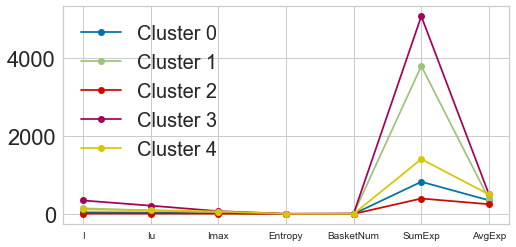

In [25]:
plt.figure(figsize=(8,4))
for i in range(0,len(centers)):
    plt.plot(centers[i],marker='o',label="Cluster %s" % i)
plt.tick_params(axis="both",which="major",labelsize=22)    
plt.xticks(range(0, len(new_df.columns)), new_df.columns, fontsize=10)
plt.legend(fontsize=20)    
plt.show()    

## DBSCAN
Parameters:

eps: The maximum distance between two samples for them to be considered as in the same neighborhood.
min_samples: The number of samples in a neighborhood for a point to be considered as a core point. This includes the point itself.
min_samples was set to twice the dimension of our dataset.

In [30]:
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from kneed import KneeLocator

min_pts = new_df.shape[1] * 2

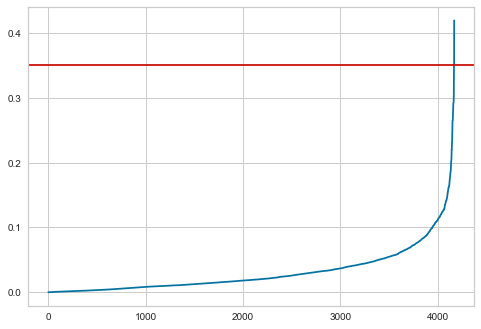

In [39]:
neighbors=NearestNeighbors(n_neighbors=min_pts)
neighbors_fit=neighbors.fit(df_transformed)
distances, indices = neighbors_fit.kneighbors(df_transformed)
distances = np.sort(distances, axis=0)
distances = distances[:,1]
kneedle = KneeLocator(range(distances.shape[0]), distances, S=1.0, curve="convex", direction="increasing")
plt.plot(range(distances.shape[0]), distances)
eps = kneedle.knee_y
plt.axhline(y=eps, color='r', linestyle='-', label="eps")
plt.show()

In [41]:
dbscan=DBSCAN(eps=eps,min_samples=min_pts)
dbscan.fit(df_transformed)

DBSCAN(eps=0.35098101261991416, min_samples=14)

In [42]:
labels,counts=np.unique(dbscan.labels_,return_counts=True)
print(labels, counts)

[-1  0] [  15 4156]


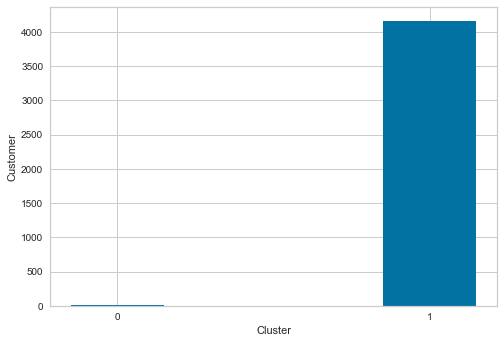

In [43]:
plt.bar(x=range(len(counts)), height=counts, width=0.3)
plt.xticks(np.arange(2))
plt.xlabel("Cluster")
plt.ylabel("Customer")
plt.show()

In [45]:
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage,dendrogram,fcluster

def hierarchical(method, metric):
    data_dist=pdist(df_transformed,metric=metric)
    data_link = linkage(data_dist, method=method, metric=metric)
    dendrogram(data_link, truncate_mode='lastp')

    max_d = 0.7*max(data_link[:,2])
    app = fcluster(data_link, max_d, criterion='distance')
    print(np.unique(app, return_counts=True))

(array([1, 2, 3, 4], dtype=int32), array([   2, 4167,    1,    1], dtype=int64))


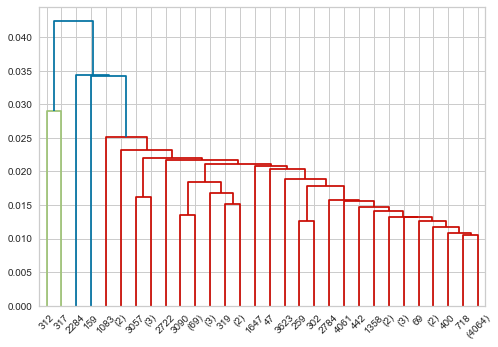

In [46]:
hierarchical(method='single', metric='cosine')

(array([1, 2, 3, 4], dtype=int32), array([  74, 1081,  126, 2890], dtype=int64))


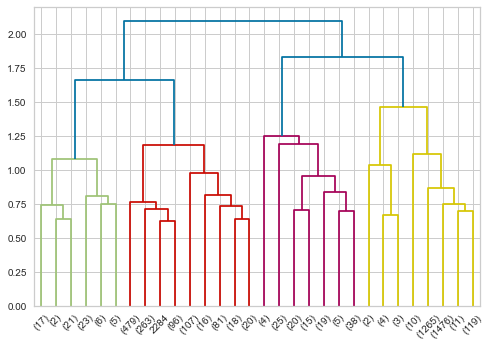

In [48]:
hierarchical(method='complete', metric='euclidean')

(array([1, 2, 3, 4], dtype=int32), array([ 155, 4008,    3,    5], dtype=int64))


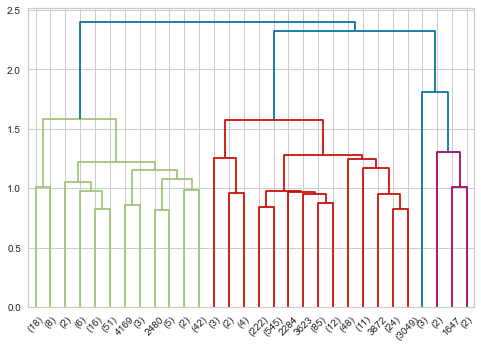

In [49]:
hierarchical(method='average', metric='cityblock')

(array([1, 2], dtype=int32), array([  76, 4095], dtype=int64))


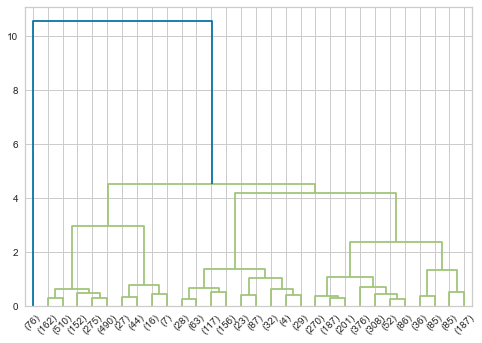

In [50]:
hierarchical(method='ward', metric='cosine')